In [68]:
import matplotlib.pyplot 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import PIL

#tsnecuda is a bit harder to install, if you want to use MulticoreTSNE instead (sklearn is too slow) 
#then uncomment the below MulticoreTSNE line, comment out the tsnecuda line, and replace 
#all TSNE() lines with TSNE(n_jobs=12), where 12 is replaced with the number of cores on your machine

#from MulticoreTSNE import MulticoreTSNE as TSNE
from tsnecuda import TSNE


from multiview.embed.splitae import SplitAE

In [69]:
# Setup plotting

%matplotlib inline
plt.style.use("default")
%config InlineBackend.figure_format = 'svg'

Let's make a simple two view dataset based on MNIST as described in http://proceedings.mlr.press/v37/wangb15.pdf . 

The "underlying data" of our views is a digit from 0-9 -- e.g. "2" or "7" or "9". 

The first view of this underlying data is a random MNIST image with the correct digit, rotated randomly +- 45 degrees.

The second view of this underlying data is another random MNIST image that's similarly rotated and with the correct digit, but with the addition of uniform noise from [0,1]

An example point of our data is:

- view1: an MNIST image with the label "9"
- view2: a different MNIST image with the label "9" with noise added.



In [70]:
class NoisyMnist(Dataset):

    MNIST_MEAN, MNIST_STD = (0.1307, 0.3081)

    def __init__(self, train=True):
        super().__init__()
        self.mnistDataset = datasets.MNIST("./mnist", train=train, download=True)

    def __len__(self):
        return len(self.mnistDataset)

    def __getitem__(self, idx):
        randomIndex = lambda: np.random.randint(len(self.mnistDataset))
        image1, label1 = self.mnistDataset[idx]
        image2, label2 = self.mnistDataset[randomIndex()]
        while not label1 == label2:
            image2, label2 = self.mnistDataset[randomIndex()]

        image1 = torchvision.transforms.RandomRotation((-45, 45), resample=PIL.Image.BICUBIC)(image1)
        image2 = torchvision.transforms.RandomRotation((-45, 45), resample=PIL.Image.BICUBIC)(image2)
        image1 = np.array(image1) / 255
        image2 = np.array(image2) / 255

        image2 = np.clip(image2 + np.random.uniform(0, 1, size=image2.shape), 0, 1) # add noise to the view2 image

        # standardize both images
        image1 = (image1 - self.MNIST_MEAN) / self.MNIST_STD
        image2 = (image2 - (self.MNIST_MEAN+0.447)) / self.MNIST_STD

        image1 = torch.FloatTensor(image1).unsqueeze(0) # image1 is view1
        image2 = torch.FloatTensor(image2).unsqueeze(0) # image2 is view2

        return (image1, image2, label1)

Let's look at this datset we made. The first row is view1 and the second row is the corresponding view2.

Dataset length is 60000


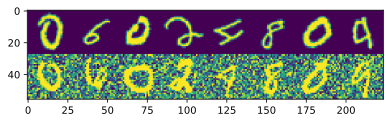

In [71]:
dataset = NoisyMnist()
print("Dataset length is", len(dataset))
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=8)
view1, view2, labels = next(iter(dataloader))

view1Row = torch.cat([*view1.squeeze()], dim=1)
view2Row = torch.cat([*view2.squeeze()], dim=1)
# make between 0 and 1 again:
view1Row = (view1Row - torch.min(view1Row)) / (torch.max(view1Row) - torch.min(view1Row))
view2Row = (view2Row - torch.min(view2Row)) / (torch.max(view2Row) - torch.min(view2Row))
plt.imshow(torch.cat([view1Row, view2Row], dim=0))

Sklearn API doesn't use Dataloaders (which hampers data augmentation :(  ) so let's get our dataset into a different format. Each view will be an array of the shape (nSamples, nFeatures). We will do the same for the test dataset.

In [72]:
# since batch_size=len(dataset), we get the full dataset with one next(iter(dataset)) call
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True, num_workers=8)
view1, view2, labels = next(iter(dataloader))
view1 = view1.view(view1.shape[0], -1)
view2 = view2.view(view2.shape[0], -1)

testDataset = NoisyMnist(train=False)
print("Test dataset length is", len(testDataset))
testDataloader = DataLoader(testDataset, batch_size=10000, shuffle=True, num_workers=8)
testView1, testView2, testLabels = next(iter(testDataloader))
testView1 = testView1.view(testView1.shape[0], -1)
testView2 = testView2.view(testView2.shape[0], -1)

Test dataset length is 10000


SplitAE does two things. It creates a shared embedding for view1 and view2. And it allows predicting view2 from view1. The autoencoder network takes in view1 as input, squeezes it into a low-dimensional representation, and then from that low-dimensional representation (the embedding), it tries to recreate view1 and predict view2. Let's see that:


  0%|          | 0/10 [00:00<?, ?it/s]

Parameter counts: 
view1Encoder: 1,863,690
view1Decoder: 1,864,464
view2Decoder: 1,864,464



 10%|█         | 1/10 [00:02<00:24,  2.74s/it]

Average train error during epoch 0 was 1.4699246763673603
Average test  error during epoch 0 was 1.3223426342010498




 20%|██        | 2/10 [00:05<00:22,  2.76s/it]

Average train error during epoch 1 was 1.2588642188626478
Average test  error during epoch 1 was 1.2276697158813477




 30%|███       | 3/10 [00:08<00:19,  2.76s/it]

Average train error during epoch 2 was 1.1916472517017624
Average test  error during epoch 2 was 1.1881365776062012




 40%|████      | 4/10 [00:10<00:16,  2.72s/it]

Average train error during epoch 3 was 1.1562376824709086
Average test  error during epoch 3 was 1.1488428115844727




 50%|█████     | 5/10 [00:13<00:13,  2.73s/it]

Average train error during epoch 4 was 1.1355234804825904
Average test  error during epoch 4 was 1.1403299570083618




 60%|██████    | 6/10 [00:16<00:10,  2.75s/it]

Average train error during epoch 5 was 1.1223415617759411
Average test  error during epoch 5 was 1.1054173707962036




 70%|███████   | 7/10 [00:19<00:08,  2.75s/it]

Average train error during epoch 6 was 1.1124326691158817
Average test  error during epoch 6 was 1.112804889678955




 80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

Average train error during epoch 7 was 1.1047027103411846
Average test  error during epoch 7 was 1.1143605709075928




 90%|█████████ | 9/10 [00:24<00:02,  2.70s/it]

Average train error during epoch 8 was 1.0985518711754398
Average test  error during epoch 8 was 1.0993146896362305




100%|██████████| 10/10 [00:27<00:00,  2.73s/it]

Average train error during epoch 9 was 1.0936348486659873
Average test  error during epoch 9 was 1.1125755310058594



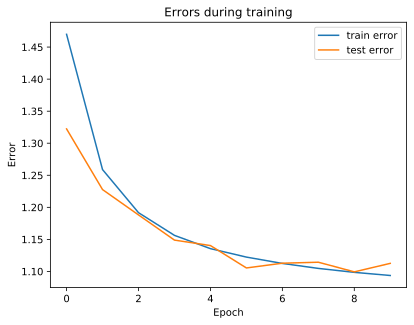

In [73]:
splitae = SplitAE(hiddenSize=1024, numHiddenLayers=2, embedSize=10, trainingEpochs=10, batchSize=128, learningRate=0.001)
splitae.fit([view1, view2], validationXs=[testView1, testView2]) 
# if the named parameter validationXs is passed with held-out data, then .fit will print validation error as well.

We can see from the graph that test error did not diverge from train error, which means we're not overfitting, which is good! Let's see the actual view1 recreation and the view2 prediction on test data:

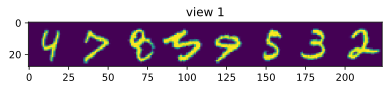

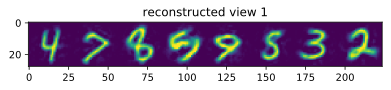

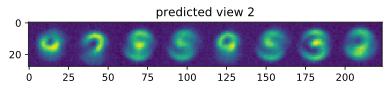

In [74]:
MNIST_MEAN, MNIST_STD = (0.1307, 0.3081)
testEmbed, testView1Reconstruction, testView2Prediction = splitae.transform([testView1, testView2])
numImages = 8
randIndices = np.random.choice(range(len(testDataset)), numImages, replace=False)
def plotRow(title, view):
    samples = view[randIndices].reshape(-1, 28, 28)
    row = np.concatenate([*samples], axis=1)
    row = np.clip(row * MNIST_STD + MNIST_MEAN, 0, 1) #denormalize
    plt.imshow(row)
    plt.title(title)
    plt.show()
plotRow("view 1", testView1)
plotRow("reconstructed view 1", testView1Reconstruction)
plotRow("predicted view 2", testView2Prediction)

Notice the view 2 predictions. In most of the predictions, the correct digit is visible, but there is a hazy circle surrounding it. This is because of the way we augmented our data. Say the network can perfectly decipher an image of a digit (view1) to get the actual digit. What view2 image could correspond to that digit? It could be any image of that digit rotated by somewhere between -45 and 45 degrees. Hence the network predicts something like the mean of all these rotations and we get a hazy circle.

Next let's visualize our 20d test embeddings with T-SNE and see if they represent our original underlying representation -- the digits from 0-9 -- of which we made two views of. In the perfect scenario, each of the 10,000 vectors of our test embedding would be one of ten vectors, representing the digits from 0-9. (Our network wouldn't do this, as it tries to reconstruct each unique view1 image exactly). In lieu of this we can hope for embedding vectors corresponding to the same digits to be closer together. 

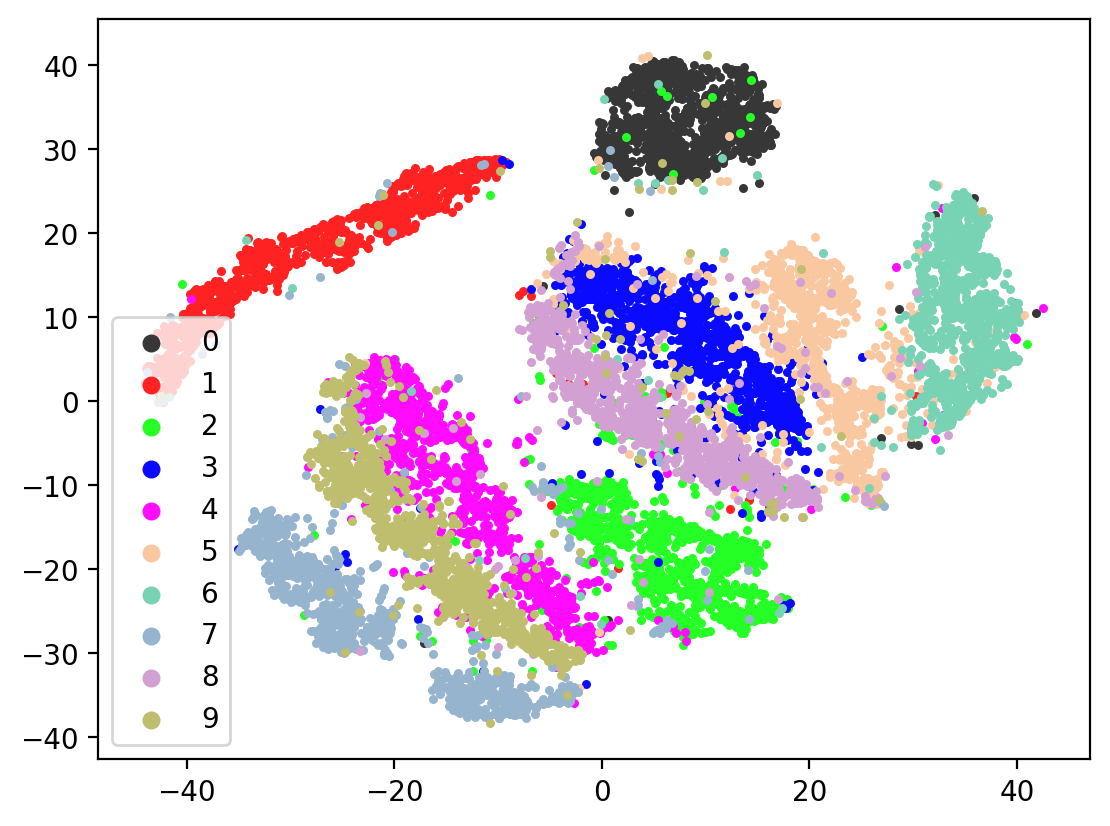

In [75]:
%config InlineBackend.figure_format = 'retina'

tsne = TSNE()
tsneEmbeddings = tsne.fit_transform(testEmbed)

def plot2DEmbeddings(embeddings, labels):
    pointColors = []
    origColors = [[55, 55, 55], [255, 34, 34], [38, 255, 38], [10, 10, 255], [255, 12, 255], [250, 200, 160], [120, 210, 180], [150, 180, 205], [210, 160, 210], [190, 190, 110]]
    origColors = (np.array(origColors)) / 255
    for l in labels.cpu().numpy():
        pointColors.append(tuple(origColors[l].tolist()))

    fig, ax = plt.subplots()
    #scatter = ax.scatter(*tsneEmbeddings.transpose(), c=pointColors, s=5)
    for i, label in enumerate(np.unique(labels)):
        idxs = np.where(testLabels == label)
        ax.scatter(embeddings[idxs][:, 0], embeddings[idxs][:, 1], c=[origColors[i]], label=i, s=5)

    legend = plt.legend(loc="lower left")
    for handle in legend.legendHandles:
        handle.set_sizes([30.0])
    plt.show()

plot2DEmbeddings(tsneEmbeddings, testLabels)

This is the image we're trying to reproduce:

![image](https://raw.githubusercontent.com/NeuroDataDesign/multiview/cameronfranz/Screen%20Shot%202019-12-08%20at%209.59.45%20PM.png)


Lets check the variability of multiple TSNE runs:

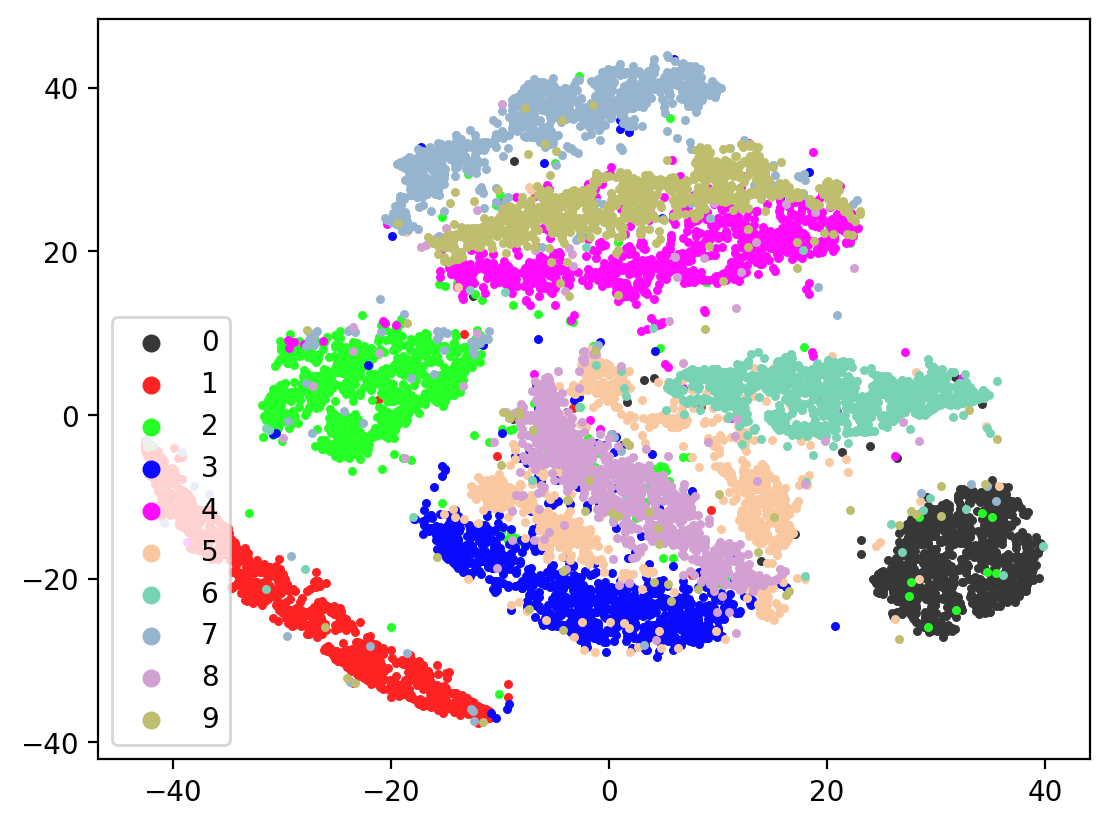

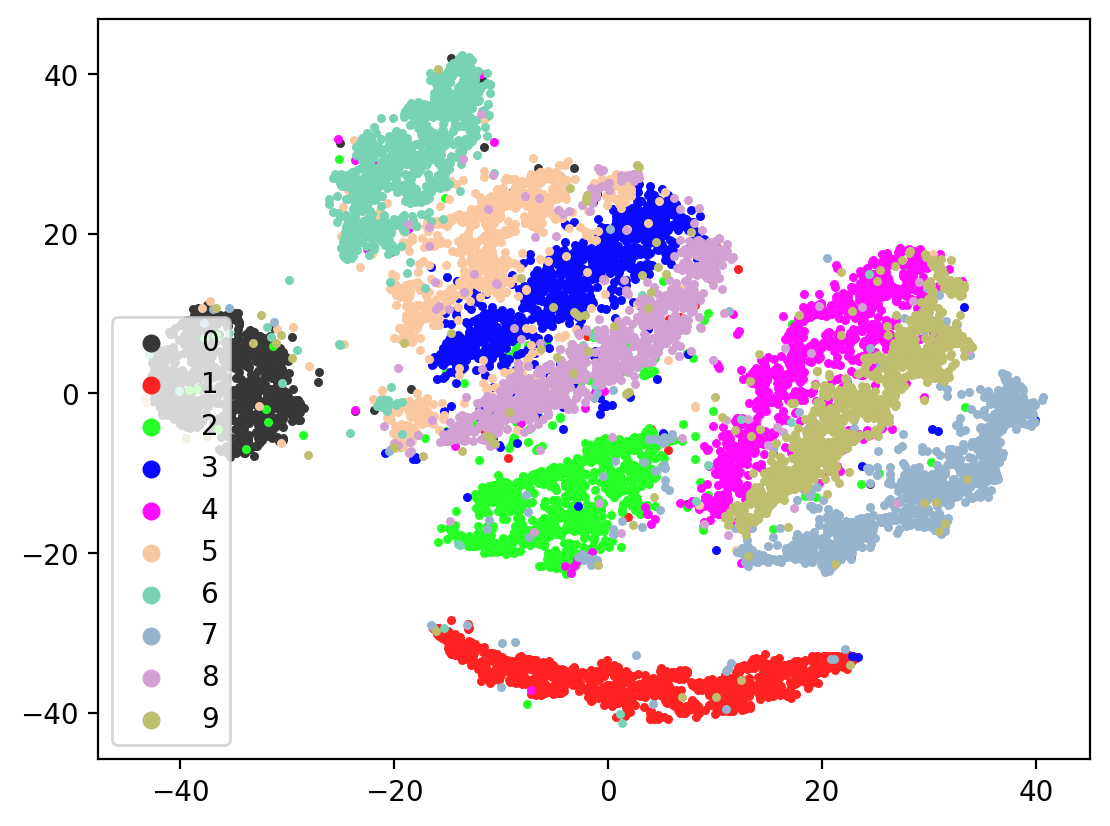

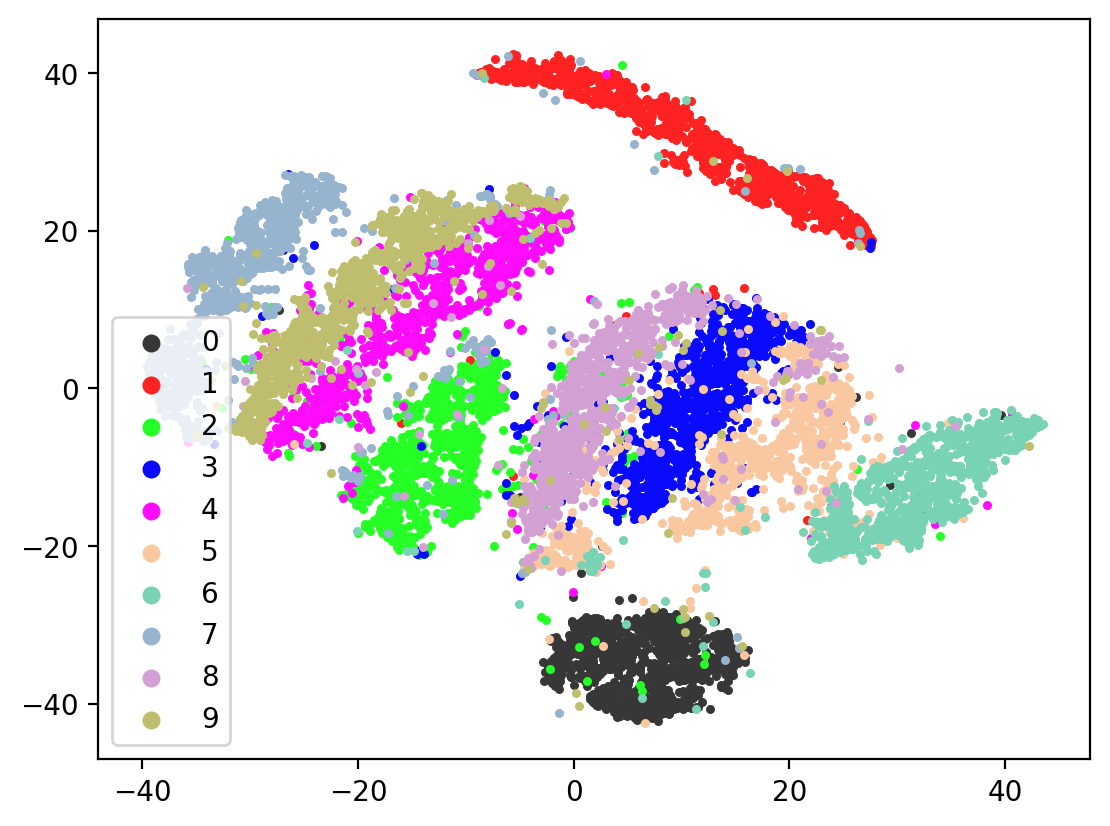

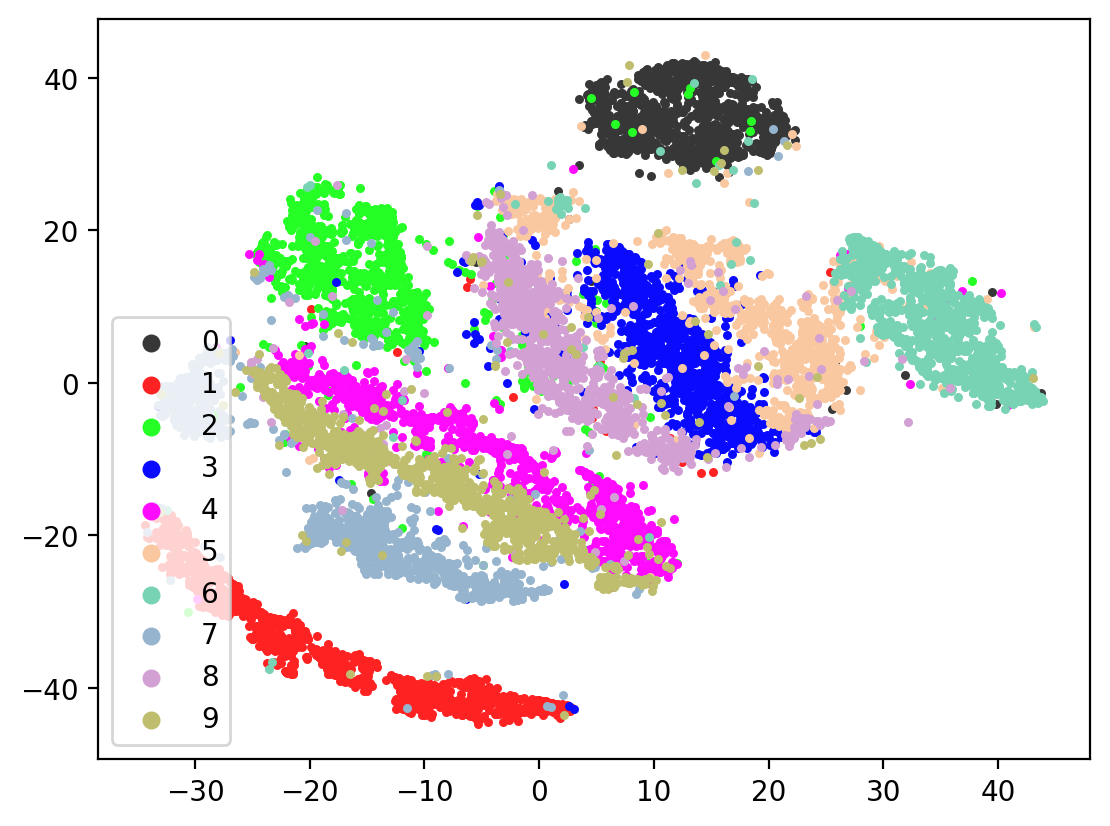

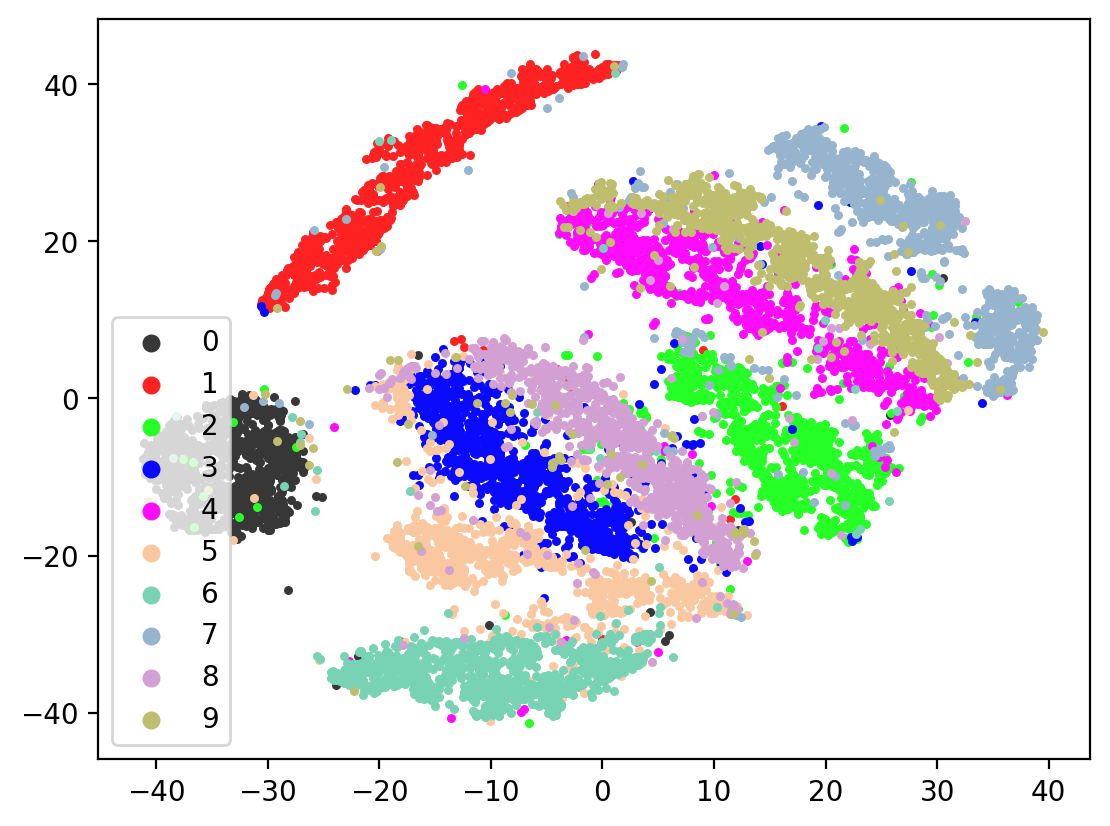

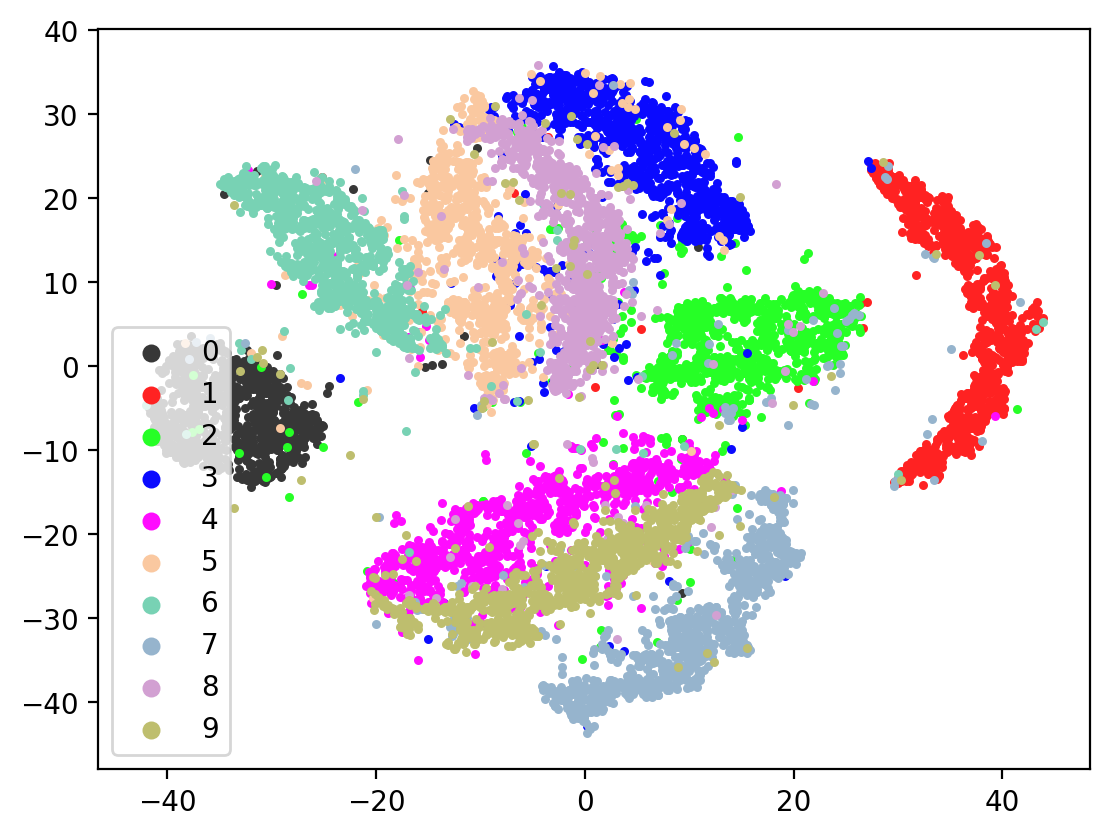

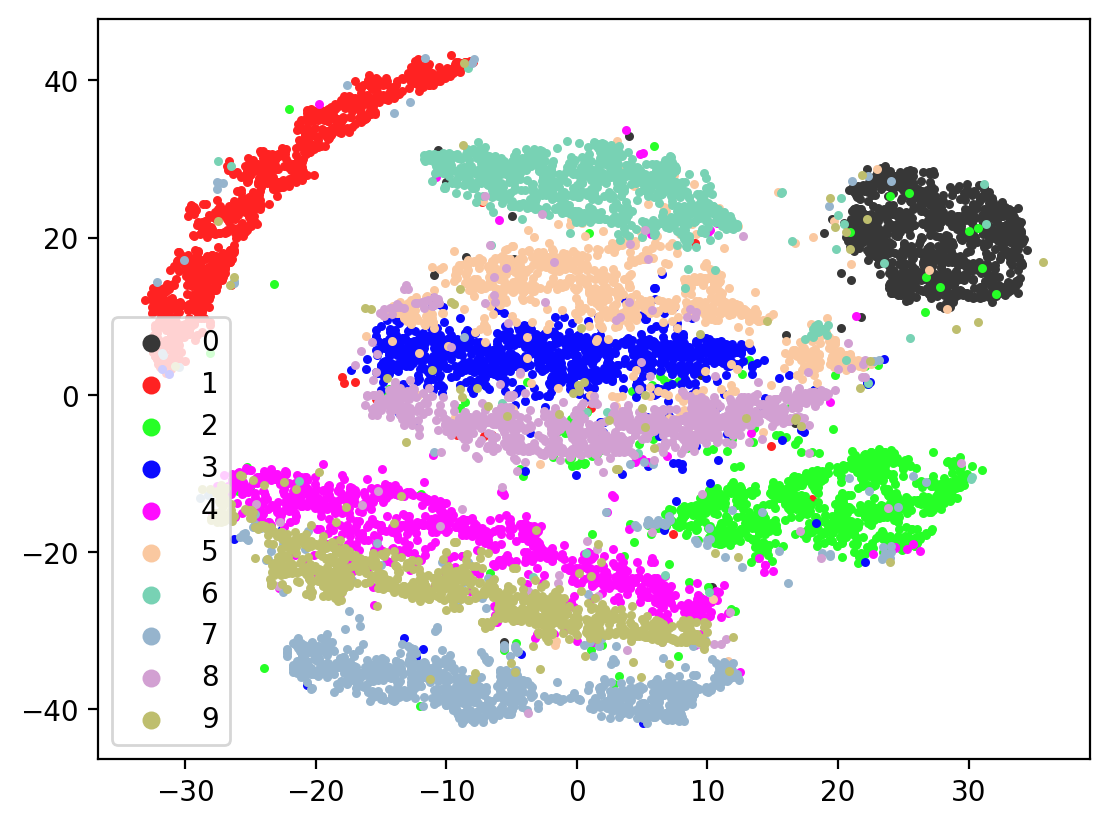

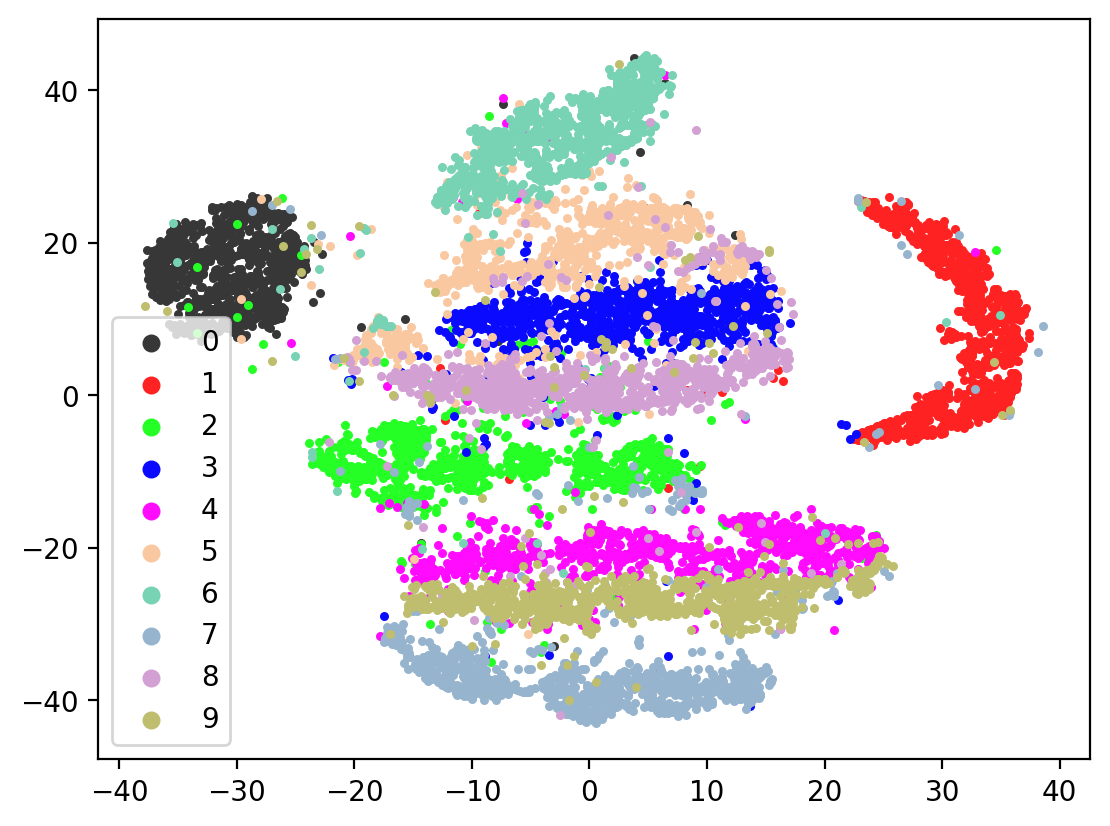

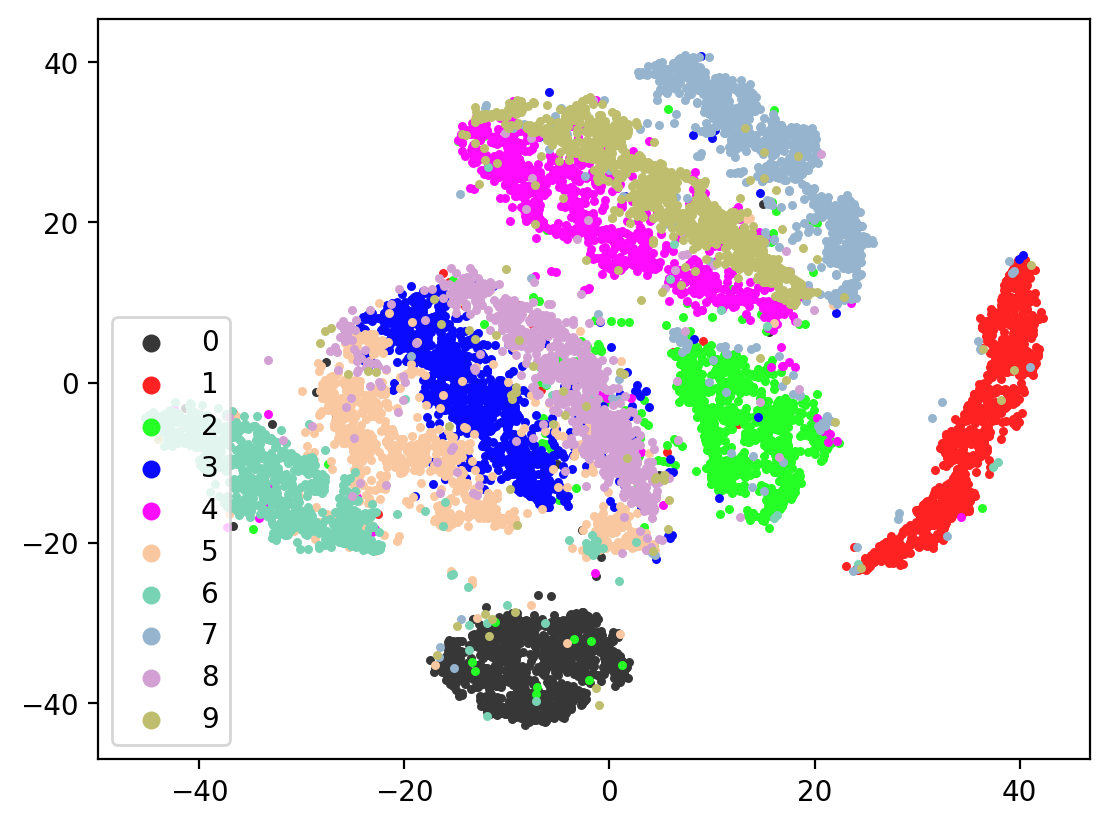

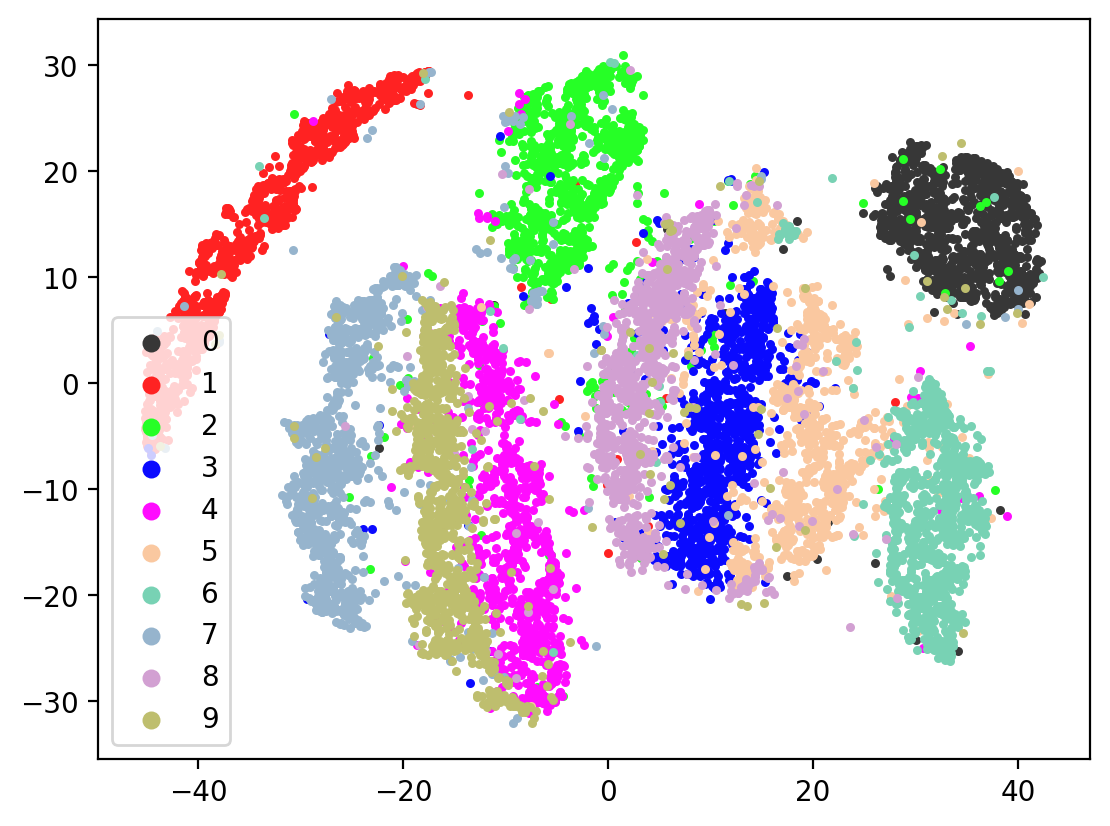

In [76]:
for i in range(10):
    tsneEmbeddings = tsne.fit_transform(testEmbed)
    plot2DEmbeddings(tsneEmbeddings, testLabels)

Now let's check the variability of both training the model plus TSNE-ing the test embeddings.


  0%|          | 0/12 [00:00<?, ?it/s]

Parameter counts: 
view1Encoder: 1,863,690
view1Decoder: 1,864,464
view2Decoder: 1,864,464



  8%|▊         | 1/12 [00:02<00:28,  2.61s/it]

Average train error during epoch 0 was 1.4766441433348207



 17%|█▋        | 2/12 [00:05<00:26,  2.65s/it]

Average train error during epoch 1 was 1.2539220913353128



 25%|██▌       | 3/12 [00:07<00:23,  2.65s/it]

Average train error during epoch 2 was 1.1848128420165462



 33%|███▎      | 4/12 [00:10<00:21,  2.63s/it]

Average train error during epoch 3 was 1.1513477492536235



 42%|████▏     | 5/12 [00:13<00:18,  2.63s/it]

Average train error during epoch 4 was 1.1322896793866768



 50%|█████     | 6/12 [00:15<00:15,  2.63s/it]

Average train error during epoch 5 was 1.1196427778301077



 58%|█████▊    | 7/12 [00:18<00:13,  2.65s/it]

Average train error during epoch 6 was 1.1101871349363246



 67%|██████▋   | 8/12 [00:21<00:10,  2.66s/it]

Average train error during epoch 7 was 1.1024988362422357



 75%|███████▌  | 9/12 [00:23<00:07,  2.65s/it]

Average train error during epoch 8 was 1.0964083169770038



 83%|████████▎ | 10/12 [00:26<00:05,  2.67s/it]

Average train error during epoch 9 was 1.0918082597418728



 92%|█████████▏| 11/12 [00:29<00:02,  2.68s/it]

Average train error during epoch 10 was 1.087665591484461



100%|██████████| 12/12 [00:31<00:00,  2.66s/it]

Average train error during epoch 11 was 1.0836955079665551


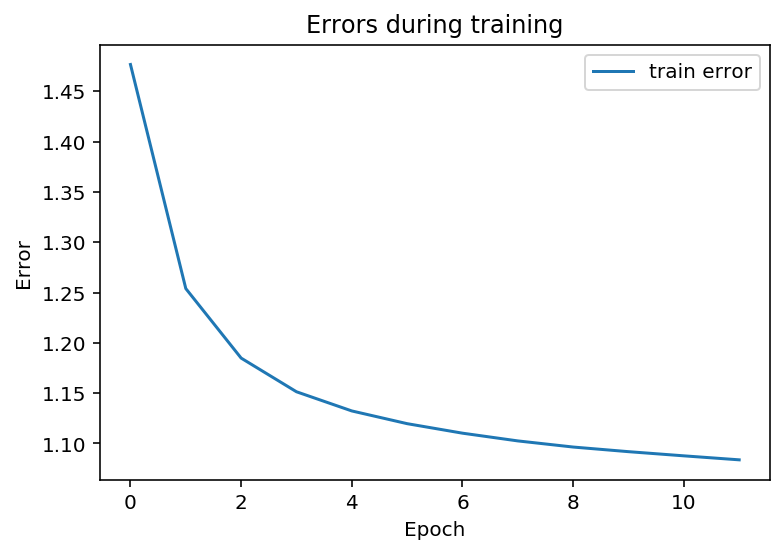

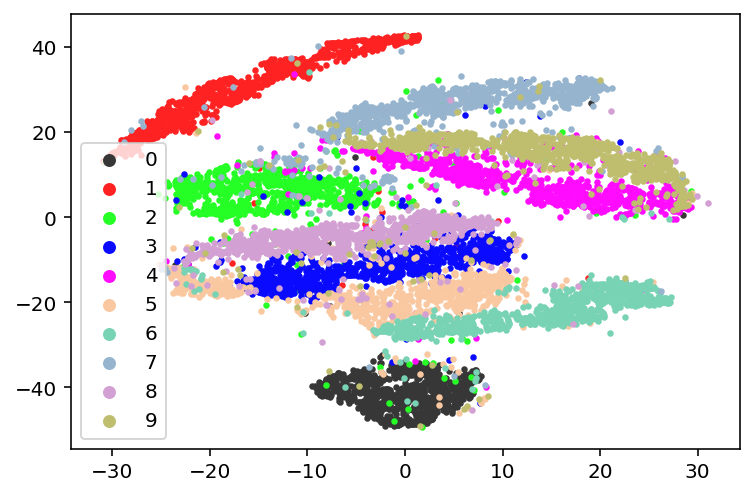


  0%|          | 0/12 [00:00<?, ?it/s]

Parameter counts: 
view1Encoder: 1,863,690
view1Decoder: 1,864,464
view2Decoder: 1,864,464



  8%|▊         | 1/12 [00:02<00:32,  2.96s/it]

Average train error during epoch 0 was 1.4909342629277809



 17%|█▋        | 2/12 [00:05<00:29,  2.93s/it]

Average train error during epoch 1 was 1.2738916907045577



 25%|██▌       | 3/12 [00:08<00:26,  2.90s/it]

Average train error during epoch 2 was 1.2152339418729146



 33%|███▎      | 4/12 [00:11<00:22,  2.81s/it]

Average train error during epoch 3 was 1.173955828206152



 42%|████▏     | 5/12 [00:13<00:19,  2.73s/it]

Average train error during epoch 4 was 1.1487749211299114



 50%|█████     | 6/12 [00:16<00:16,  2.70s/it]

Average train error during epoch 5 was 1.1324694327309601



 58%|█████▊    | 7/12 [00:19<00:13,  2.68s/it]

Average train error during epoch 6 was 1.121210345855126



 67%|██████▋   | 8/12 [00:21<00:10,  2.68s/it]

Average train error during epoch 7 was 1.1125914322005377



 75%|███████▌  | 9/12 [00:24<00:08,  2.68s/it]

Average train error during epoch 8 was 1.1054481252645836



 83%|████████▎ | 10/12 [00:27<00:05,  2.71s/it]

Average train error during epoch 9 was 1.0998518138359754



 92%|█████████▏| 11/12 [00:29<00:02,  2.67s/it]

Average train error during epoch 10 was 1.0957207111721365



100%|██████████| 12/12 [00:32<00:00,  2.70s/it]

Average train error during epoch 11 was 1.0914783266365018


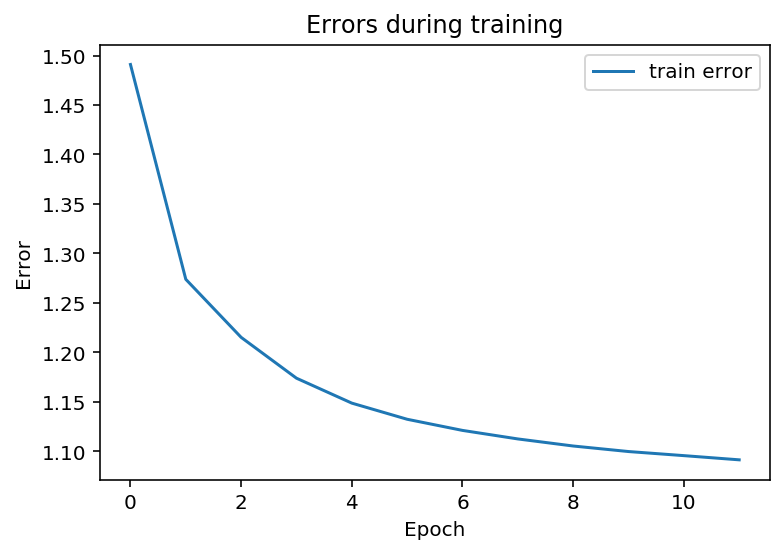

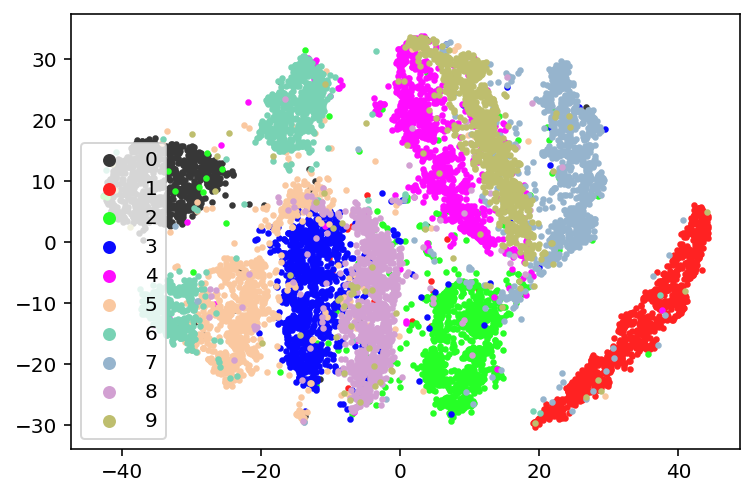


  0%|          | 0/12 [00:00<?, ?it/s]

Parameter counts: 
view1Encoder: 1,863,690
view1Decoder: 1,864,464
view2Decoder: 1,864,464



  8%|▊         | 1/12 [00:02<00:28,  2.61s/it]

Average train error during epoch 0 was 1.4934329935628126



 17%|█▋        | 2/12 [00:05<00:26,  2.66s/it]

Average train error during epoch 1 was 1.2747958964771695



 25%|██▌       | 3/12 [00:07<00:23,  2.64s/it]

Average train error during epoch 2 was 1.2022474428527377



 33%|███▎      | 4/12 [00:10<00:21,  2.66s/it]

Average train error during epoch 3 was 1.1612595500599625



 42%|████▏     | 5/12 [00:13<00:18,  2.66s/it]

Average train error during epoch 4 was 1.1398732010115924



 50%|█████     | 6/12 [00:15<00:15,  2.65s/it]

Average train error during epoch 5 was 1.1258520213966696



 58%|█████▊    | 7/12 [00:18<00:13,  2.63s/it]

Average train error during epoch 6 was 1.1157639380703626



 67%|██████▋   | 8/12 [00:21<00:10,  2.64s/it]

Average train error during epoch 7 was 1.107549612593447



 75%|███████▌  | 9/12 [00:23<00:07,  2.63s/it]

Average train error during epoch 8 was 1.1009922801938832



 83%|████████▎ | 10/12 [00:26<00:05,  2.65s/it]

Average train error during epoch 9 was 1.095739085959573



 92%|█████████▏| 11/12 [00:29<00:02,  2.67s/it]

Average train error during epoch 10 was 1.0913889726512453



100%|██████████| 12/12 [00:31<00:00,  2.66s/it]

Average train error during epoch 11 was 1.0875219509132907


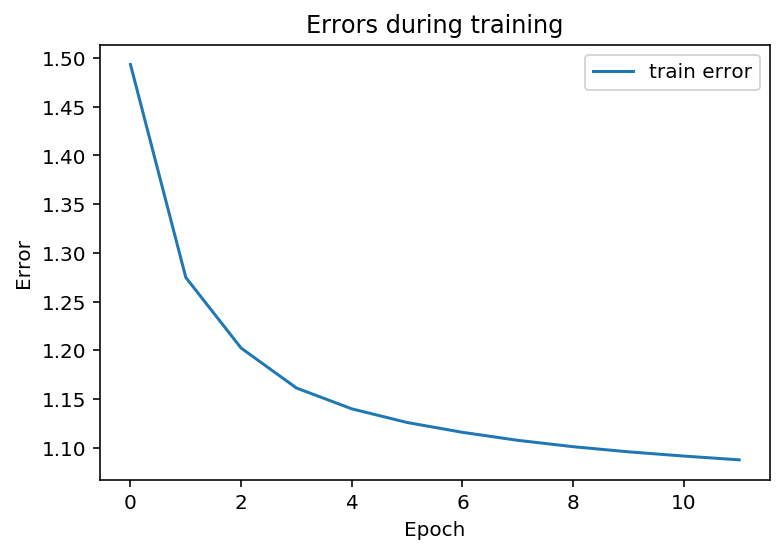

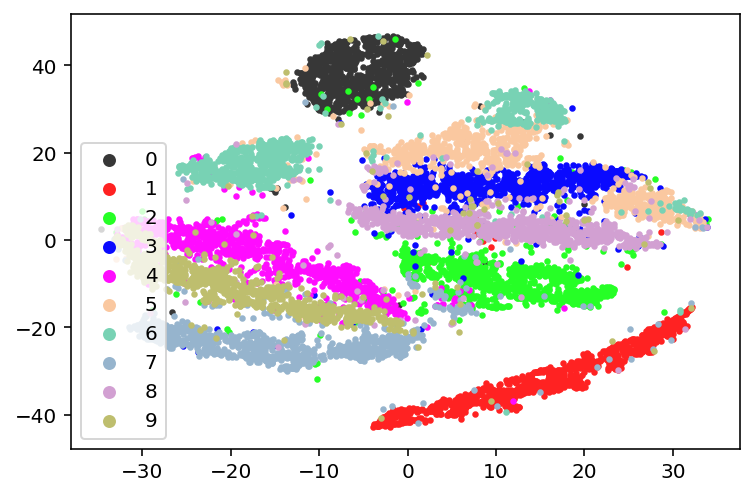


  0%|          | 0/12 [00:00<?, ?it/s]

Parameter counts: 
view1Encoder: 1,863,690
view1Decoder: 1,864,464
view2Decoder: 1,864,464



  8%|▊         | 1/12 [00:02<00:29,  2.65s/it]

Average train error during epoch 0 was 1.4709450801213582



 17%|█▋        | 2/12 [00:05<00:26,  2.62s/it]

Average train error during epoch 1 was 1.2623758881520002



 25%|██▌       | 3/12 [00:07<00:23,  2.65s/it]

Average train error during epoch 2 was 1.1929771400924423



 33%|███▎      | 4/12 [00:10<00:21,  2.68s/it]

Average train error during epoch 3 was 1.1560671693748898



 42%|████▏     | 5/12 [00:13<00:19,  2.82s/it]

Average train error during epoch 4 was 1.1362502610581553



 50%|█████     | 6/12 [00:16<00:16,  2.83s/it]

Average train error during epoch 5 was 1.1229828109598567



 58%|█████▊    | 7/12 [00:19<00:14,  2.81s/it]

Average train error during epoch 6 was 1.113222355516548



 67%|██████▋   | 8/12 [00:22<00:11,  2.81s/it]

Average train error during epoch 7 was 1.1054848689808805



 75%|███████▌  | 9/12 [00:24<00:08,  2.77s/it]

Average train error during epoch 8 was 1.0996127434265919



 83%|████████▎ | 10/12 [00:27<00:05,  2.77s/it]

Average train error during epoch 9 was 1.0945175065953507



 92%|█████████▏| 11/12 [00:30<00:02,  2.77s/it]

Average train error during epoch 10 was 1.0900339104680934



100%|██████████| 12/12 [00:33<00:00,  2.76s/it]

Average train error during epoch 11 was 1.0862566973918524


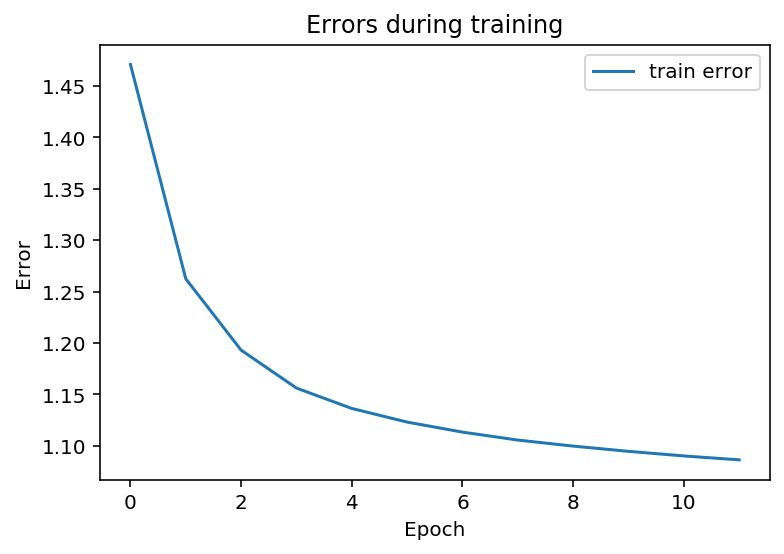

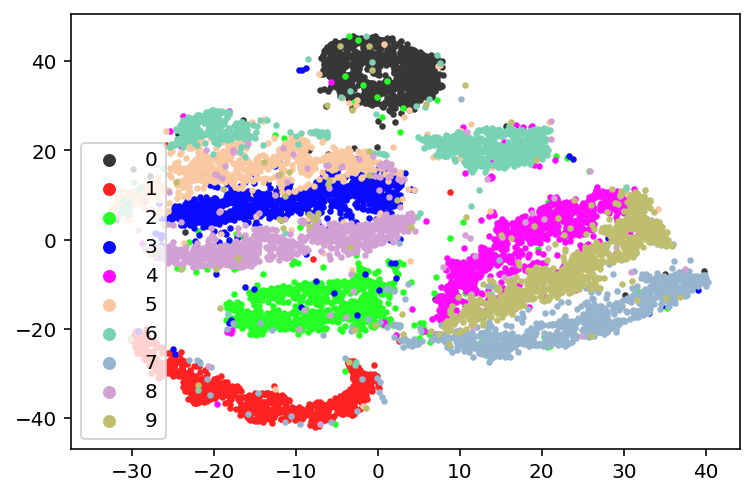


  0%|          | 0/12 [00:00<?, ?it/s]

Parameter counts: 
view1Encoder: 1,863,690
view1Decoder: 1,864,464
view2Decoder: 1,864,464



  8%|▊         | 1/12 [00:02<00:29,  2.67s/it]

Average train error during epoch 0 was 1.4793683023024828



 17%|█▋        | 2/12 [00:05<00:26,  2.68s/it]

Average train error during epoch 1 was 1.2585745209302657



 25%|██▌       | 3/12 [00:08<00:24,  2.70s/it]

Average train error during epoch 2 was 1.1922581394513447



 33%|███▎      | 4/12 [00:10<00:21,  2.70s/it]

Average train error during epoch 3 was 1.1576526817093549



 42%|████▏     | 5/12 [00:13<00:18,  2.70s/it]

Average train error during epoch 4 was 1.135990765104946



 50%|█████     | 6/12 [00:16<00:16,  2.69s/it]

Average train error during epoch 5 was 1.121869649642553



 58%|█████▊    | 7/12 [00:18<00:13,  2.70s/it]

Average train error during epoch 6 was 1.1113972455008416



 67%|██████▋   | 8/12 [00:21<00:10,  2.68s/it]

Average train error during epoch 7 was 1.103146280743118



 75%|███████▌  | 9/12 [00:24<00:08,  2.72s/it]

Average train error during epoch 8 was 1.0966537671211438



 83%|████████▎ | 10/12 [00:27<00:05,  2.71s/it]

Average train error during epoch 9 was 1.091579707005085



 92%|█████████▏| 11/12 [00:29<00:02,  2.70s/it]

Average train error during epoch 10 was 1.086943800887491



100%|██████████| 12/12 [00:32<00:00,  2.70s/it]

Average train error during epoch 11 was 1.082672815801751


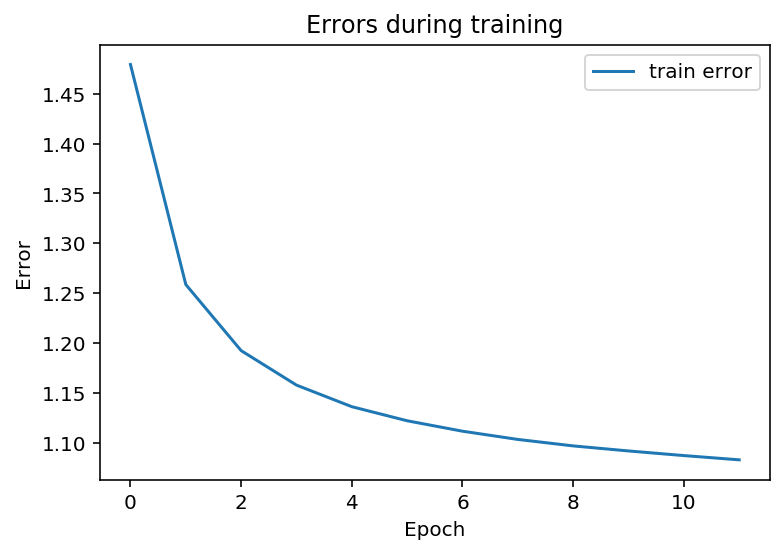

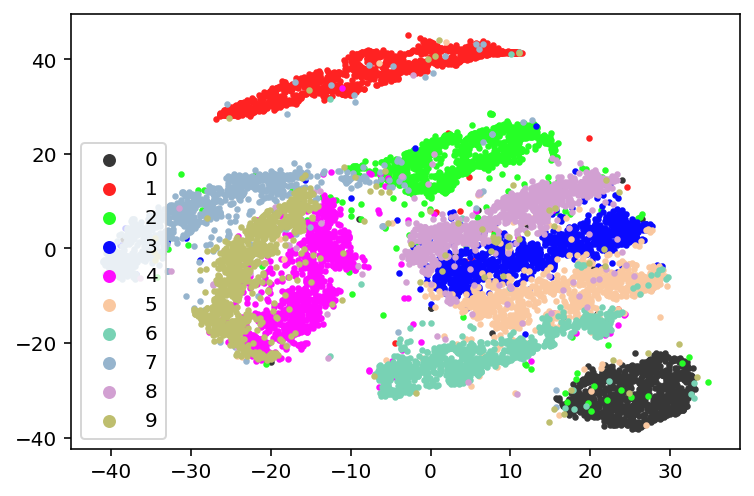


  0%|          | 0/12 [00:00<?, ?it/s]

Parameter counts: 
view1Encoder: 1,863,690
view1Decoder: 1,864,464
view2Decoder: 1,864,464



  8%|▊         | 1/12 [00:02<00:29,  2.69s/it]

Average train error during epoch 0 was 1.4568924348578494



 17%|█▋        | 2/12 [00:05<00:26,  2.68s/it]

Average train error during epoch 1 was 1.2541378145543938



 25%|██▌       | 3/12 [00:08<00:24,  2.68s/it]

Average train error during epoch 2 was 1.1856737141935234



 33%|███▎      | 4/12 [00:10<00:21,  2.67s/it]

Average train error during epoch 3 was 1.15362498189649



 42%|████▏     | 5/12 [00:13<00:18,  2.70s/it]

Average train error during epoch 4 was 1.1347517302403083



 50%|█████     | 6/12 [00:16<00:16,  2.69s/it]

Average train error during epoch 5 was 1.1220566790837507



 58%|█████▊    | 7/12 [00:18<00:13,  2.74s/it]

Average train error during epoch 6 was 1.112332637493427



 67%|██████▋   | 8/12 [00:21<00:11,  2.76s/it]

Average train error during epoch 7 was 1.104919825354193



 75%|███████▌  | 9/12 [00:24<00:08,  2.73s/it]

Average train error during epoch 8 was 1.09908545577628



 83%|████████▎ | 10/12 [00:27<00:05,  2.72s/it]

Average train error during epoch 9 was 1.093951548011894



 92%|█████████▏| 11/12 [00:29<00:02,  2.70s/it]

Average train error during epoch 10 was 1.0895561140317183



100%|██████████| 12/12 [00:32<00:00,  2.71s/it]

Average train error during epoch 11 was 1.085687868615501


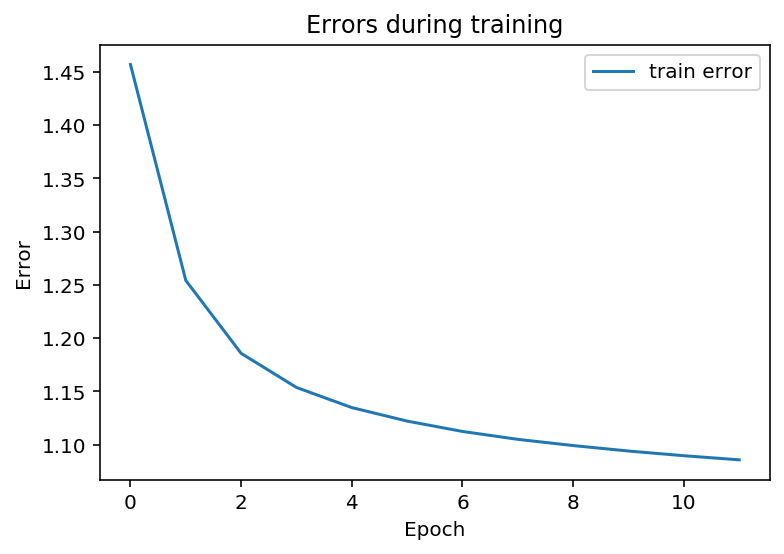

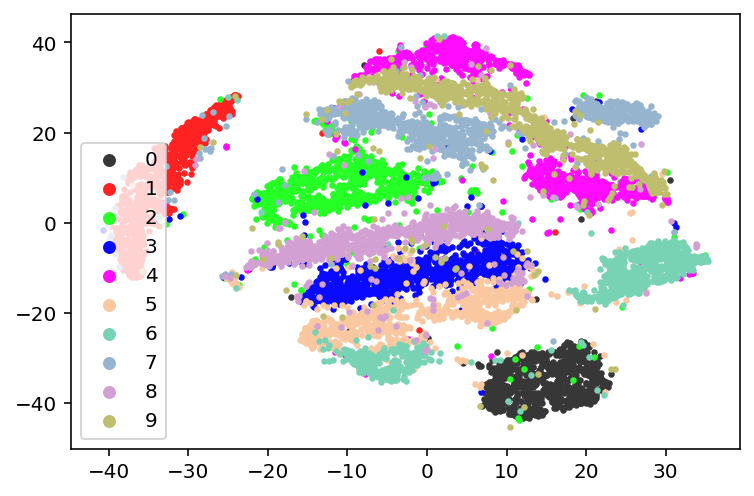


  0%|          | 0/12 [00:00<?, ?it/s]

Parameter counts: 
view1Encoder: 1,863,690
view1Decoder: 1,864,464
view2Decoder: 1,864,464



  8%|▊         | 1/12 [00:02<00:30,  2.78s/it]

Average train error during epoch 0 was 1.4821394559664605



 17%|█▋        | 2/12 [00:05<00:27,  2.76s/it]

Average train error during epoch 1 was 1.2655000933724592



 25%|██▌       | 3/12 [00:08<00:24,  2.73s/it]

Average train error during epoch 2 was 1.2034886160976865



 33%|███▎      | 4/12 [00:10<00:21,  2.69s/it]

Average train error during epoch 3 was 1.1617495817506416



 42%|████▏     | 5/12 [00:13<00:18,  2.68s/it]

Average train error during epoch 4 was 1.140767579149996



 50%|█████     | 6/12 [00:16<00:16,  2.67s/it]

Average train error during epoch 5 was 1.1272599118897038



 58%|█████▊    | 7/12 [00:18<00:13,  2.67s/it]

Average train error during epoch 6 was 1.1173540157640083



 67%|██████▋   | 8/12 [00:21<00:10,  2.68s/it]

Average train error during epoch 7 was 1.1093023635892787



 75%|███████▌  | 9/12 [00:24<00:08,  2.69s/it]

Average train error during epoch 8 was 1.102979468738931



 83%|████████▎ | 10/12 [00:26<00:05,  2.69s/it]

Average train error during epoch 9 was 1.0979769815746536



 92%|█████████▏| 11/12 [00:29<00:02,  2.68s/it]

Average train error during epoch 10 was 1.093594012606857



100%|██████████| 12/12 [00:32<00:00,  2.68s/it]

Average train error during epoch 11 was 1.0894124319410732


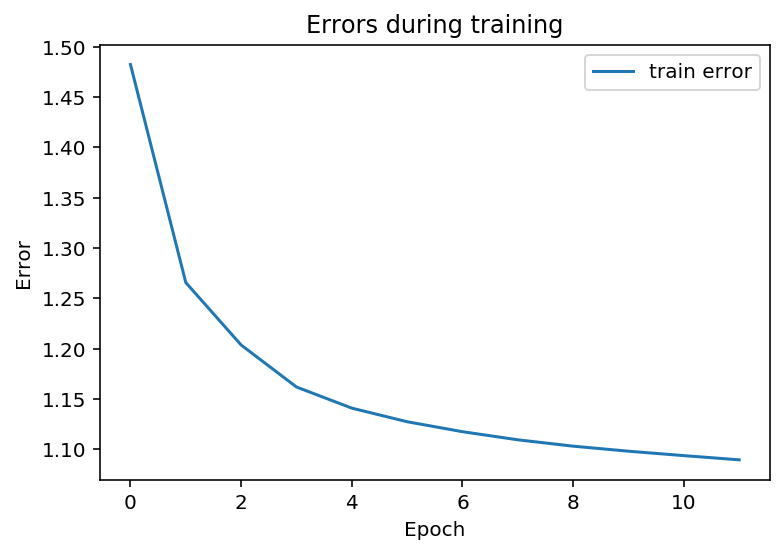

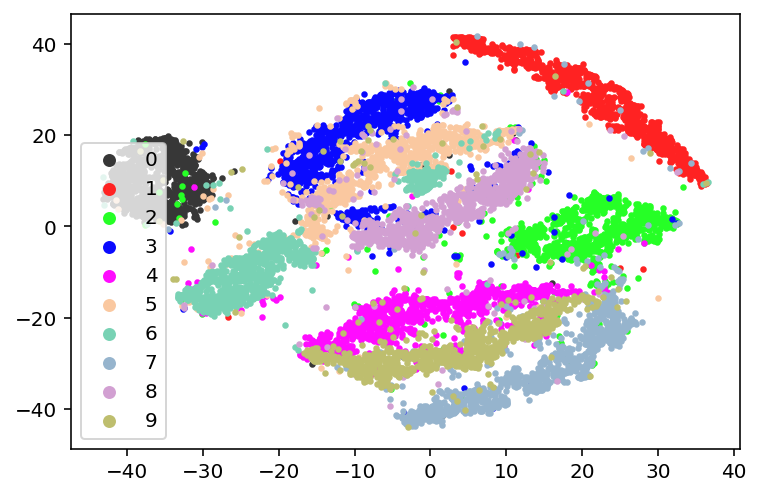


  0%|          | 0/12 [00:00<?, ?it/s]

Parameter counts: 
view1Encoder: 1,863,690
view1Decoder: 1,864,464
view2Decoder: 1,864,464



  8%|▊         | 1/12 [00:02<00:29,  2.68s/it]

Average train error during epoch 0 was 1.4576544397407107



 17%|█▋        | 2/12 [00:05<00:26,  2.67s/it]

Average train error during epoch 1 was 1.2600659452951872



 25%|██▌       | 3/12 [00:08<00:24,  2.69s/it]

Average train error during epoch 2 was 1.1939266869145582



 33%|███▎      | 4/12 [00:10<00:21,  2.72s/it]

Average train error during epoch 3 was 1.1572173143553937



 42%|████▏     | 5/12 [00:13<00:18,  2.71s/it]

Average train error during epoch 4 was 1.1374598629454262



 50%|█████     | 6/12 [00:16<00:16,  2.69s/it]

Average train error during epoch 5 was 1.1243024771539574



 58%|█████▊    | 7/12 [00:18<00:13,  2.68s/it]

Average train error during epoch 6 was 1.1146230476024823



 67%|██████▋   | 8/12 [00:21<00:10,  2.69s/it]

Average train error during epoch 7 was 1.1070505029115922



 75%|███████▌  | 9/12 [00:24<00:08,  2.70s/it]

Average train error during epoch 8 was 1.1007704905465119



 83%|████████▎ | 10/12 [00:26<00:05,  2.70s/it]

Average train error during epoch 9 was 1.0955488824436808



 92%|█████████▏| 11/12 [00:29<00:02,  2.69s/it]

Average train error during epoch 10 was 1.0915097668130174



100%|██████████| 12/12 [00:32<00:00,  2.69s/it]

Average train error during epoch 11 was 1.0880832312962947


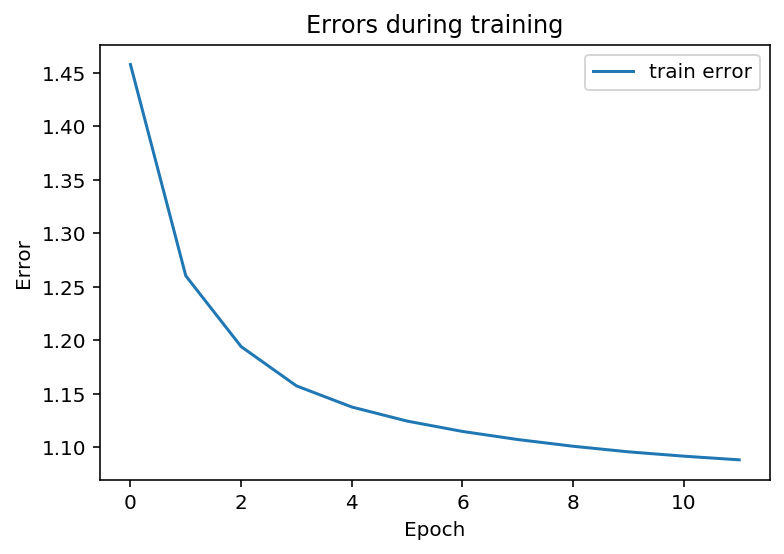

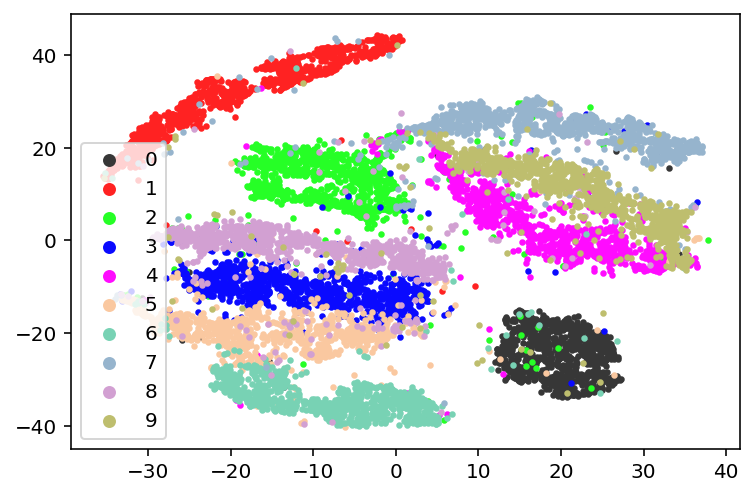


  0%|          | 0/12 [00:00<?, ?it/s]

Parameter counts: 
view1Encoder: 1,863,690
view1Decoder: 1,864,464
view2Decoder: 1,864,464



  8%|▊         | 1/12 [00:02<00:29,  2.65s/it]

Average train error during epoch 0 was 1.4841102348943043



 17%|█▋        | 2/12 [00:05<00:26,  2.65s/it]

Average train error during epoch 1 was 1.2635715830529857



 25%|██▌       | 3/12 [00:08<00:24,  2.68s/it]

Average train error during epoch 2 was 1.1919980716501546



 33%|███▎      | 4/12 [00:10<00:21,  2.69s/it]

Average train error during epoch 3 was 1.156330314456907



 42%|████▏     | 5/12 [00:13<00:18,  2.69s/it]

Average train error during epoch 4 was 1.1361090176635318



 50%|█████     | 6/12 [00:16<00:16,  2.69s/it]

Average train error during epoch 5 was 1.1230325112994919



 58%|█████▊    | 7/12 [00:18<00:13,  2.69s/it]

Average train error during epoch 6 was 1.1133317539834569



 67%|██████▋   | 8/12 [00:21<00:10,  2.72s/it]

Average train error during epoch 7 was 1.1059533248090336



 75%|███████▌  | 9/12 [00:24<00:08,  2.74s/it]

Average train error during epoch 8 was 1.099636797212128



 83%|████████▎ | 10/12 [00:27<00:05,  2.74s/it]

Average train error during epoch 9 was 1.0944349640964444



 92%|█████████▏| 11/12 [00:29<00:02,  2.71s/it]

Average train error during epoch 10 was 1.0905085521885471



100%|██████████| 12/12 [00:32<00:00,  2.70s/it]

Average train error during epoch 11 was 1.0870506600437002


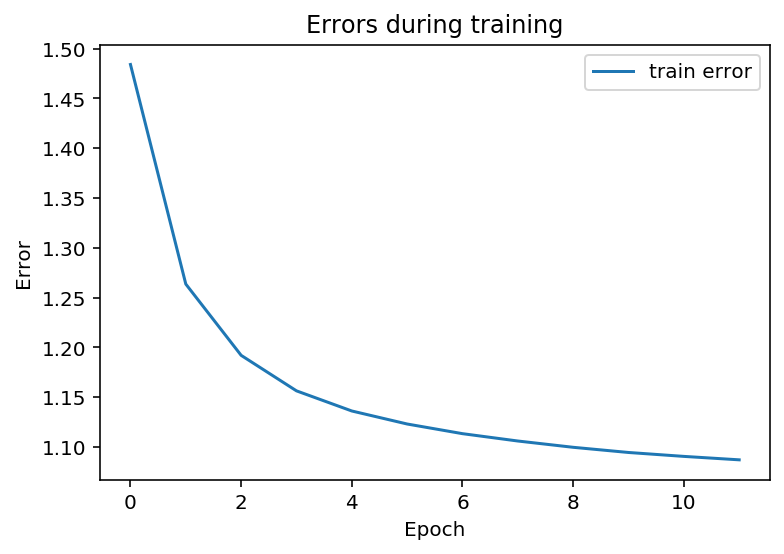

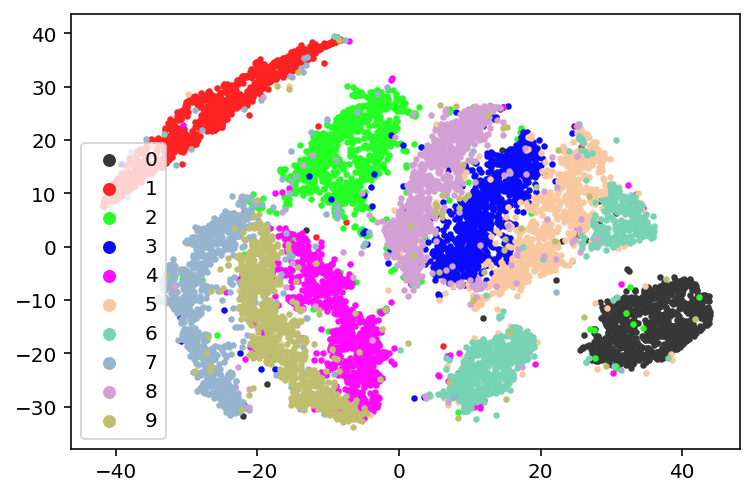


  0%|          | 0/12 [00:00<?, ?it/s]

Parameter counts: 
view1Encoder: 1,863,690
view1Decoder: 1,864,464
view2Decoder: 1,864,464



  8%|▊         | 1/12 [00:02<00:28,  2.63s/it]

Average train error during epoch 0 was 1.482943760788339



 17%|█▋        | 2/12 [00:05<00:26,  2.64s/it]

Average train error during epoch 1 was 1.2654464043613174



 25%|██▌       | 3/12 [00:08<00:24,  2.67s/it]

Average train error during epoch 2 was 1.195611794789632



 33%|███▎      | 4/12 [00:10<00:21,  2.71s/it]

Average train error during epoch 3 was 1.1593242631508753



 42%|████▏     | 5/12 [00:13<00:18,  2.71s/it]

Average train error during epoch 4 was 1.1386878745168703



 50%|█████     | 6/12 [00:16<00:16,  2.73s/it]

Average train error during epoch 5 was 1.1251765522691939



 58%|█████▊    | 7/12 [00:19<00:13,  2.75s/it]

Average train error during epoch 6 was 1.1154633671300025



 67%|██████▋   | 8/12 [00:21<00:10,  2.73s/it]

Average train error during epoch 7 was 1.107899946025294



 75%|███████▌  | 9/12 [00:24<00:08,  2.70s/it]

Average train error during epoch 8 was 1.101101543658819



 83%|████████▎ | 10/12 [00:27<00:05,  2.69s/it]

Average train error during epoch 9 was 1.095870109450104



 92%|█████████▏| 11/12 [00:29<00:02,  2.73s/it]

Average train error during epoch 10 was 1.0916565045332298



100%|██████████| 12/12 [00:32<00:00,  2.73s/it]

Average train error during epoch 11 was 1.087559948110173


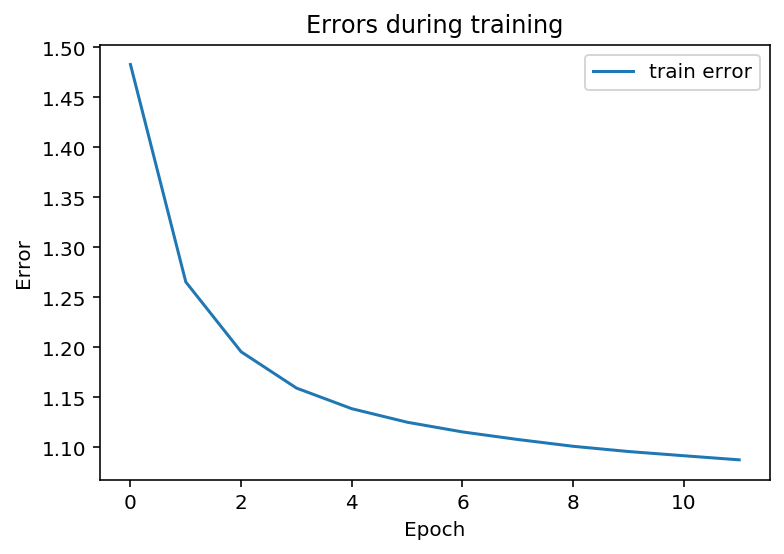

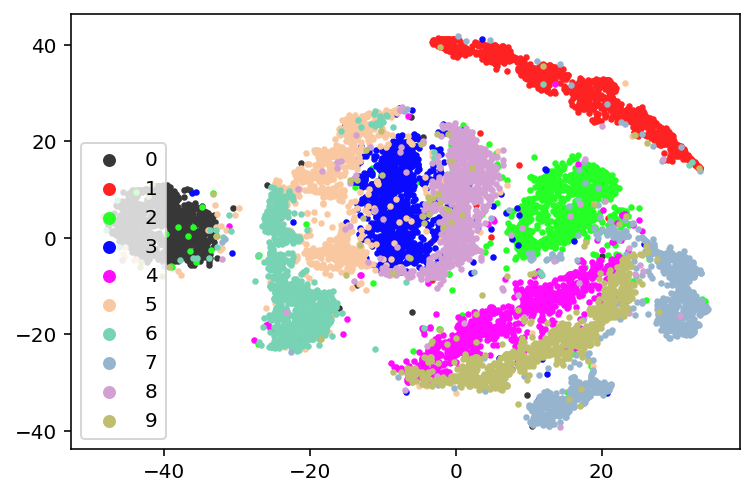

In [66]:
for i in range(10):

    splitae = SplitAE(hiddenSize=1024, numHiddenLayers=2, embedSize=10, trainingEpochs=12, batchSize=128, learningRate=0.001)
    splitae.fit([view1, view2])

    testEmbed, testView1Reconstruction, testView2Reconstruction = splitae.transform([testView1, testView2])

    tsneEmbeddings = tsne.fit_transform(testEmbed)
    plot2DEmbeddings(tsneEmbeddings, testLabels)

In most of the plots in the above cell we can see the distinct connected bands of the original figure, as well as the distinct black circular blob (corresponding to the digit 0, which appears easiest to learn). In some of the figures, a one or two bands are broken up. With more training of the network, though (stepping the learning rate), the bands converge less stretched (i.e. average distance between vectors of the same class is closer) blobs. 